In [5]:
from urllib import parse
from ast import literal_eval
import requests

def get_sise(code, start_time, end_time, time_from='day') :   # month, week
    get_param = {
    	'symbol':code,
	    'requestType':1,
	    'startTime':start_time,
	    'endTime':end_time,
	    'timeframe':time_from
    }
    get_param = parse.urlencode(get_param)
    print(get_param)
    url="https://api.finance.naver.com/siseJson.naver?%s"%(get_param)
    response = requests.get(url)
    return literal_eval(response.text.strip())
    
get_sise('278280', '20210601', '20210605', 'day')

symbol=278280&requestType=1&startTime=20210601&endTime=20210605&timeframe=day


[['날짜', '시가', '고가', '저가', '종가', '거래량', '외국인소진율'],
 ['20210601', 167400, 168400, 166100, 168000, 20754, 6.6],
 ['20210602', 168000, 169200, 167100, 167500, 29736, 6.63],
 ['20210603', 166300, 171200, 166300, 170500, 49272, 6.72],
 ['20210604', 170500, 171300, 168000, 170200, 31744, 6.72]]

In [8]:
from pykrx import stock

#data = stock.get_market_ohlcv_by_date("20210601", "20210605", "278280")  # freq         (str,  optional): d - 일 / m - 월 / y - 년
data = stock.get_market_ohlcv_by_date("20210601", "20210605", "278280","d")  # freq         (str,  optional): d - 일 / m - 월 / y - 년

print(data)

                시가      고가      저가      종가    거래량        거래대금   등락률
날짜                                                                 
2021-06-01  167400  168400  166100  168000  20754  3483719500  0.42
2021-06-02  168000  169200  167100  167500  29736  4996971600 -0.30
2021-06-03  166300  171200  166300  170500  49272  8360144800  1.79
2021-06-04  170500  171300  168000  170200  31744  5389378200 -0.18


In [11]:
# coding=utf-8

import sqlite3
import pandas as pd
import tqdm

In [13]:
def get_sise(stock_code, try_cnt):
    try:
        url="http://asp1.krx.co.kr/servlet/krx.asp.XMLSiseEng?code={}".format(
stock_code)
        req=urlopen(url)
        result=req.read()
        xmlsoup=BeautifulSoup(result,"lxml-xml")
        stock = xmlsoup.find("TBL_StockInfo")

        stock_df=pd.DataFrame(stock.attrs, index=[0])
        stock_df=stock_df.applymap(lambda x: x.replace(",",""))

        return stock_df
    except HTTPError as e:
        logging.warning(e)
        if try_cnt>=3:
            return None
        else:
            get_sise(stock_code,try_cnt=+1)

# 주식 시세 DB에 저장하기
con=sqlite3.connect("./div.db")
stock_code=['005930','066570']

#for s in tqdm(stock_code):
for s in stock_code:    
    temp=get_sise(s,1)
    temp.to_sql(con=con,name="div_stock_sise",if_exists="append")
    time.sleep(0.5)
con.close()



NameError: name 'HTTPError' is not defined

In [14]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pykrx import stock

import matplotlib.pyplot as plt

# 총 종목 설정
stock_list_stock = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="KOSPI")})
stock_list_stock1 = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="KOSDAQ")})
stock_list_stock = pd.concat([stock_list_stock, stock_list_stock1], axis=0, ignore_index=True)
stock_list_stock['종목명'] = stock_list_stock['종목코드'].map(lambda x: stock.get_market_ticker_name(x))
stock_list_etf = pd.DataFrame({'종목코드':stock.get_etf_ticker_list(datetime.today().strftime('%Y%m%d'))})
stock_list_etf['종목명'] = stock_list_etf['종목코드'].map(lambda x: stock.get_etf_ticker_name(x))



In [15]:
# 종목 ohlcv
def stock_stock(stock_code, stock_from, stock_to):
    # 종목
    stock_name = stock_list_stock.loc[stock_list_stock['종목코드'] == stock_code, '종목명']
    if str(stock_name.values) == '[]':
        stock_name = stock_list_etf.loc[stock_list_etf['종목코드']==stock_code, '종목명']
    df = stock.get_market_ohlcv_by_date(fromdate=stock_from, todate=stock_to, ticker=stock_code)

    # 칼럼명을 영문명으로 변경
    df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
    df['Close']=df['Close'].apply(pd.to_numeric,errors="coerce")
    df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
    df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
    df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
    df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
    # 거래정리 시
    for i in range(len(df)):
        if df['Open'].iloc[i] == 0:
            df['Open'].iloc[i] = df['Close'].iloc[i]
            df['High'].iloc[i] = df['Close'].iloc[i]
            df['Low'].iloc[i] = df['Close'].iloc[i]
    return df, stock_name.values
 

In [16]:
stock_list_stock = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="KOSPI")})

In [17]:
# 코스피 모든 종목의 종목코드 가져오기

stock_list_stock1 = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="KOSDAQ")})

In [18]:
# 코스닥 모든 종목의 종목코드 가져오기

stock_list_stock = pd.concat([stock_list_stock, stock_list_stock1], axis=0, ignore_index=True)

In [19]:
# 코스피와 코스닥 종목코드 합치기

stock_list_stock['종목명'] = stock_list_stock['종목코드'].map(lambda x: stock.get_market_ticker_name(x))

In [20]:
# 종목코드에 맞는 종목명을 추가합니다.

stock_list_etf = pd.DataFrame({'종목코드':stock.get_etf_ticker_list(datetime.today().strftime('%Y%m%d'))})

In [21]:
# ETF 모든 종목의 종목코드 가져오기

stock_list_etf['종목명'] = stock_list_etf['종목코드'].map(lambda x: stock.get_etf_ticker_name(x))

In [ ]:
# ETF 종목코드에 맞는 ETF 종목명을 추가합니다.
def stock_stock(stock_code, stock_from, stock_to):
    # 종목코드에 해당하는 종목의 OHLC 데이터를 받아옵니다.

# 20일 이동평균선, 볼린저밴드를 계산합니다.

In [23]:
codes = '278280'

In [29]:
# 종목코드에 해당하는 종목의 OHLC 데이터를 받아옵니다.

# 20일 이동평균선, 볼린저밴드를 계산합니다.

# 4. Matplotlib 차트 데이터
def matgraph(i,code):
    stock_from = (datetime.today() - timedelta(days=50)).strftime('%Y%m%d')
    stock_to = datetime.today().strftime('%Y%m%d')

    df, stock_name = stock_stock(code,stock_from,stock_to)
    print(df)
    plt.subplot(1,len(codes),i)
    plt.hlines(df['upper'][-1],0,2,color='red', zorder = 0)
    plt.hlines(df['ma20'][-1],0,2,color='black', zorder = 0)
    plt.hlines(df['lower'][-1],0,2,color='blue', zorder = 0)
    # 금일 데이터
    if df['Open'][-1] < df['Close'][-1]:
        plt.vlines(1,df['Open'][-1],df['Close'][-1],color='red',linewidth=5, zorder = 2)
    else:
        plt.vlines(1,df['Open'][-1],df['Close'][-1],color='blue',linewidth=5, zorder = 2)

    if df['Open'][-1] < df['Close'][-1]:
        plt.vlines(1,df['Low'][-1],df['High'][-1],color='red', zorder = 0)
    else:
        if df['Open'][-1] > df['Close'][-1]:
            plt.vlines(1,df['Low'][-1],df['High'][-1],color='blue', zorder = 0)
        else:
            plt.vlines(1,df['Low'][-1],df['High'][-1],color='black', zorder = 0)
            plt.plot(1,df['Close'][-1],marker='_',color='black', zorder = 2)
    # 전일 데이터
    if df['Open'][-2] < df['Close'][-2]:
        plt.vlines(0.5,df['Open'][-2],df['Close'][-2],color='red',linewidth=5, zorder = 2)
    else:
        plt.vlines(0.5,df['Open'][-2],df['Close'][-2],color='blue',linewidth=5, zorder = 2)

    if df['Open'][-2] < df['Close'][-2]:
        plt.vlines(0.5,df['Low'][-2],df['High'][-2],color='red', zorder = 0)
    else:
        if df['Open'][-2] > df['Close'][-2]:
            plt.vlines(0.5,df['Low'][-2],df['High'][-2],color='blue', zorder = 0)
        else:
            plt.vlines(0.5,df['Low'][-2],df['High'][-2],color='black', zorder = 0)
            plt.plot(0.5,df['Close'][-2],marker='_',color='black', zorder = 2)

    plt.title(stock_name)
    plt.grid(axis='y')
    plt.tight_layout()
    
    plt.subplot(1,len(codes),i)
    
    # 조회할 종목의 수만큼 subplot을 할당합니다.

    plt.hlines(df['upper'][-1],0,2,color='red', zorder = 0)
    # 오늘 볼린저 상단 밴드를 빨강으로 직선을 그립니다.

    plt.hlines(df['ma20'][-1],0,2,color='black', zorder = 0)
    
    # 오늘 20일 이동평균선을 검정으로 직선을 그립니다.
    
    plt.hlines(df['lower'][-1],0,2,color='blue', zorder = 0)
    
    # 오늘 볼린저 하단 밴드를 파랑으로 직선을 그립니다.
    
    plt.title(stock_name)
    
    # 종목명을 제목으로 추가합니다.
    
    plt.grid(axis='y')
    
    # y축 그리드를 추가합니다.
    
    plt.tight_layout()
    
    # 그래프 여백을 줄입니다.

             Open   High    Low  Close    Volume           거래대금   등락률  \
날짜                                                                      
2023-03-14  59400  59500  59000  59000  12147346   719193357800 -1.67   
2023-03-15  60000  60300  59600  59800  10482149   628405799682  1.36   
2023-03-16  59200  60200  59100  59900  10611939   633331744600  0.17   
2023-03-17  60800  61300  60600  61300  14090110   860201343960  2.34   
2023-03-20  61100  61200  60200  60200   9618009   582445819345 -1.79   
2023-03-21  60500  60700  60100  60300   8318514   501917706700  0.17   
2023-03-22  61000  61200  60500  61100   8978591   546787085426  1.33   
2023-03-23  60600  62300  60600  62300  15381057   946393607300  1.96   
2023-03-24  62700  63300  62300  63000  18278602  1147804584500  1.12   
2023-03-27  62600  62800  62000  62100  11039331   687170094400 -1.43   
2023-03-28  62400  62900  62100  62900  11614118   726295104112  1.29   
2023-03-29  62500  62700  62200  62700  11216008   

C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.


             Open   High    Low  Close    Volume           거래대금   등락률  \
날짜                                                                      
2023-03-14  82600  83000  81100  81100   3359381   274475371900 -3.80   
2023-03-15  81900  82300  78800  79100   5357314   430419363094 -2.47   
2023-03-16  76700  80200  76700  79000   4804196   379790459748 -0.13   
2023-03-17  81200  84800  81100  84000   6239588   519703504600  6.33   
2023-03-20  83800  85100  83000  83700   2223378   186420482200 -0.36   
2023-03-21  84100  85100  82900  83600   1880231   157972273100 -0.12   
2023-03-22  85200  87300  83800  86900   2667268   228244628000  3.95   
2023-03-23  85400  88500  85100  88500   3091673   269658409250  1.84   
2023-03-24  89100  90700  86700  87300   4670908   412119310916 -1.36   
2023-03-27  87500  87800  84700  85500   3211190   275196944500 -2.06   
2023-03-28  85300  88700  85200  88400   3180431   277976981700  3.39   
2023-03-29  87400  88700  86500  86900   3070422   

C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 45769 (\N{HANGUL SYLLABLE NIG}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.p

              Open    High     Low   Close   Volume          거래대금   등락률  \
날짜                                                                        
2023-03-14  200000  202000  196000  196000   776395  153758130300 -3.21   
2023-03-15  200000  201000  194500  196400   838555  165201461900  0.20   
2023-03-16  193600  198400  192100  197100   708127  139021532433  0.36   
2023-03-17  201000  202000  197200  198000   778496  154732549600  0.46   
2023-03-20  198000  204000  198000  201500   602589  121585915900  1.77   
2023-03-21  202500  203500  200000  200500   403322   81070506500 -0.50   
2023-03-22  203500  207500  203000  207000   655503  134407109500  3.24   
2023-03-23  204000  205000  202000  204000   607503  123675421000 -1.45   
2023-03-24  204500  204500  200500  202500   599102  121086558500 -0.74   
2023-03-27  201500  202000  198200  199300   611569  121929314900 -1.58   
2023-03-28  199600  201000  197800  199500   586388  116774872500  0.10   
2023-03-29  198000  20100

C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
C:\Users\USER\.conda\envs\test01\lib\site-packages\ipykernel_launcher.py:4

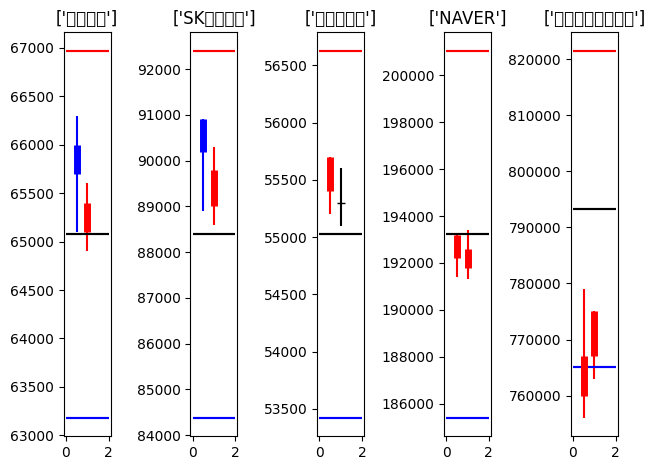

KeyboardInterrupt: 

In [30]:
# 5.  Matplotlib 차트 그리기
# 메인
fig = plt.figure()
while True:
    i=0
    fig.clear()
    codes = ['005930','000660','005935','035420','207940']
    for code in codes:
        i+=1
        matgraph(i,code)
    plt.draw() 
    plt.pause(5)
codes = ['005930','000660','005935','035420','207940']

# 조회할 종목의 종목코드를 추가해주세요.

# 개별종목과 ETF 종목 조회 가능합니다. (코넥스와 기타 종목은 코드 수정으로 가능합니다.)

plt.pause(5)

# 5초간 대기합니다.

# 5초마다 그래프가 갱신됩니다. (원하시는 시간으로 수정해주세요.)
 

In [ ]:
	def GetData_10080(self, itemInfo, day0=None):
		trCode = 'opt10080'
		print("Downloading bunData ...... : ", trCode, ' :', itemInfo['ItemCode'], ':', itemInfo['ItemName'], ' ... ', )
		Data_10080 = []
		itemCode = itemInfo['ItemCode']
		time1 = time()
		time1 = self.WaitRequestInterval(time1)
		#print("[10080]", time1)
		df = self.kiwoom.block_request(trCode,
									종목코드=itemCode,
									틱범위= 1,
									output="주식분봉차트조회요청",
									next=0
		)
		#print(df.head())
		rets1 = self.ExtractData_10080(df)
		if not rets1: return None
		for ret1 in rets1:
			Data_10080.append(ret1)
		if day0: 
			length11 = len(rets1)
			day11 = rets1[length11-1]['day'] # '20210101'
			if day11 < day0:
				return Data_10080

		while self.kiwoom.tr_remained:
			time1 = self.WaitRequestInterval(time1)
			#print("[10080]", time1)
			df = self.kiwoom.block_request(trCode,
										종목코드=itemCode,
										틱범위= 1,
										output="주식분봉차트조회요청",
										next=2
			)
			#print(df.head())
			try:
				rets1 = self.ExtractData_10080(df)
				if not rets1: break
				for ret1 in rets1:
					Data_10080.append(ret1)
			except Exception as e:
				expMessage = "[???-F06-1]"+str(e)
				self.PrintException(expMessage)
				break;
			if day0:
				length11 = len(rets1)
				day11 = rets1[length11-1]['day']
				#print('[day11]', day11)
				if day11 < day0:
					return Data_10080

		return Data_10080